# Time Series Analysis of Hipparcos

This time series analysis of Hipparcos data was an endeavor to substantiate the presence of relevant planet signals for the high, proper-motion G-type star HD 20794.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.timeseries import LombScargle

### Fonts and Sizes

Here we keep variables to have consistent fonts and plot sizes throughout this analysis. 

In [2]:
title_font = 18
label_font = 14
text_font = 12
figsize = (9, 5)

### Stellar signals

These are variables holding the periods for a number of planets, with some being possible signals for planets. Specifically, planets c, f, and g are possible planet signals. These are found in the paper linked above. Planet d has the variable <tt>pld</tt> due to conflicts with the import of pandas. The planet c signal is reported to be the possible rotation period of HD~20794, so we will use that as our rp variable.

In [3]:
pb = 18.33
pc = 43.17
pld = 88.90
pe = 147.02
pf = 331.41
pg = 11.86
rp = pc

### Base Functions & Variables

Below is a single function and variables that are used throughout the notebook. The first code cell contains variables used in the following functions and contains the relevant planet signals from the previous code cell.

The <tt>freq_vlines</tt> function is for creating vertical lines at the proper positions for the each stellar signal. 

In [24]:
planets = [1/pb, 1/pc, 1/pld, 1/pe, 1/pf, 1/pg]
planet_labels = ['b (1/18.33)', 'c (1/43.17)', 'd (1/88.90)', 'e (1/147.02)', 'f (1/331.41)', 'g (1/11.86)']
color_array = ['red', 'black', 'green', 'orange', 'purple', 'magenta']

In [25]:
def freq_vlines():
    for p, p_l, c_a in zip(planets, planet_labels, color_array):
        plt.axvline(p, linestyle='--', color=c_a, alpha=0.7, label=p_l)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

## Hipparcos Dataset

We define a variable to contain the data from Hipparcos. The file path would need to be adjusted based on where you have the file. The data uses a truncated Julian date variant.

In [4]:
data = "/Users/andrewandmatthewfonseca/NWelch/HD20794/HD20794_Hipparcos_Photometric_Light_Curve.txt"
table = pd.read_table(data, comment='#', delim_whitespace=True)
colnames = ['JD-2440000', 'mag']
print(table)

     JD-2440000     mag  mag_(error)
0    7866.54190  4.3970        0.004
1    7897.26878  4.3802        0.006
2    7897.28312  4.3890        0.005
3    7927.65173  4.4131        0.009
4    7927.74064  4.3908        0.003
..          ...     ...          ...
122  9022.88118  4.6950        0.029
123  9022.89549  4.3932        0.006
124  9022.97006  4.3969        0.004
125  9022.98439  4.3959        0.004
126  9058.45401  4.3812        0.004

[127 rows x 3 columns]


## Scatter Plot and Sigma Clipping

Here we create a scatter plot using the Hipparcos data that was unpacked in the previous code cell. We also apply a sigma clipping of 3$\sigma$.

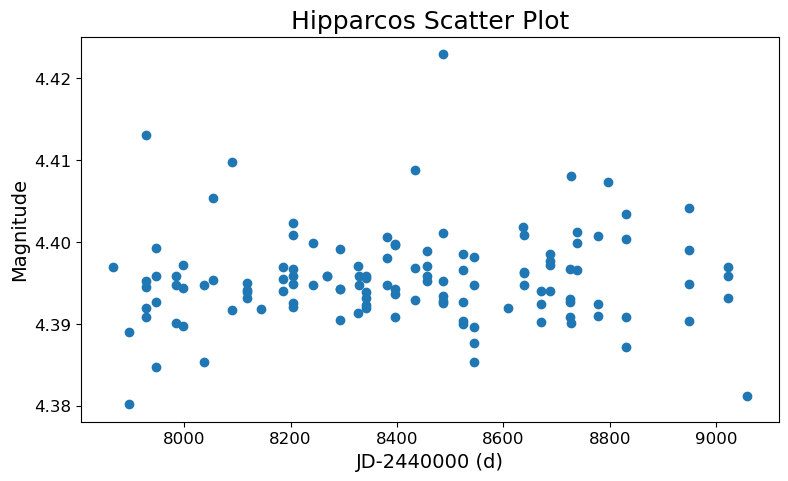

In [14]:
tjd, mag = np.loadtxt(data, skiprows=2, unpack=True, usecols=[0, 1])
std_dev = np.std(mag)

good_data = np.where(np.abs(mag - np.mean(mag)) < 3 * std_dev)[0]
tjd = tjd[good_data]
mag = mag[good_data]

plt.figure(figsize=figsize)
plt.scatter(tjd, mag)
plt.title('Hipparcos Scatter Plot', fontsize=title_font)
plt.xlabel('JD-2440000 (d)', fontsize=label_font)
plt.ylabel('Magnitude', fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.show()

tjd_full, mag_full = np.loadtxt(data, skiprows=2, unpack=True, usecols=[0, 1])

## Histrogram

We take the sigma clipped data and create a histogram of the time steps. These time steps are in log base 10.

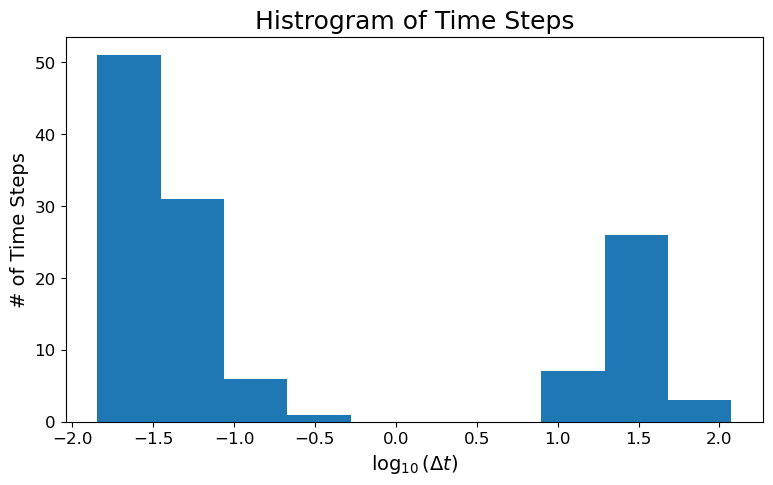

In [15]:
dt = np.diff(tjd)

plt.figure(figsize=figsize)
plt.hist(np.log10(dt))
plt.title('Histrogram of Time Steps', fontsize=title_font)
plt.xlabel(r"$\log_{10}(\Delta t)$", fontsize=label_font)
plt.ylabel('# of Time Steps', fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.show()

## Periodogram (Lower Frequencies)

We create a periodogram from the LombScargle function using the data from Hipparcos. This periodogram shows the lower frequencies. Two vertical lines are created for the signal of the rotation period and the signal divied in half, that being its harmonic.

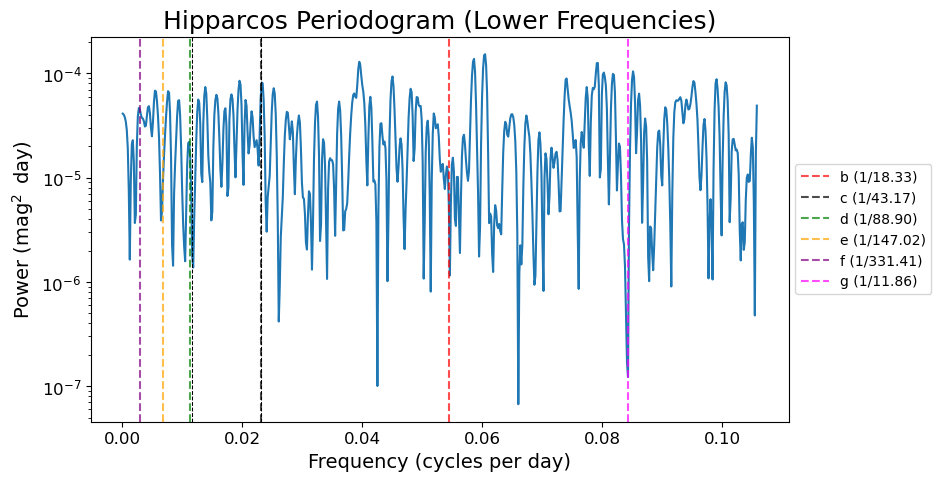

In [26]:
freq, power = LombScargle(tjd, mag, normalization = 'psd').autopower(nyquist_factor=2)

plt.figure(figsize=figsize)
plt.semilogy(freq, power)
plt.title('Hipparcos Periodogram (Lower Frequencies)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"Power ($\operatorname{mag}^2$ day)", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline((1/rp)/2, linestyle='--', linewidth=0.75, color='black')
freq_vlines()
# Can use Gaussian process for either 1/43.17 or its subharmonics 1/88.90 could explain the data if it follows it within the time of the possible rotation period of 43.17
# It also depends on how long the sun spots live.

## Periodogram (Higher Frequencies)

This is a periodogram of the clipped Hipparcos data. This has higher frequencies compared to the periodogram above that shows lower frequencies.

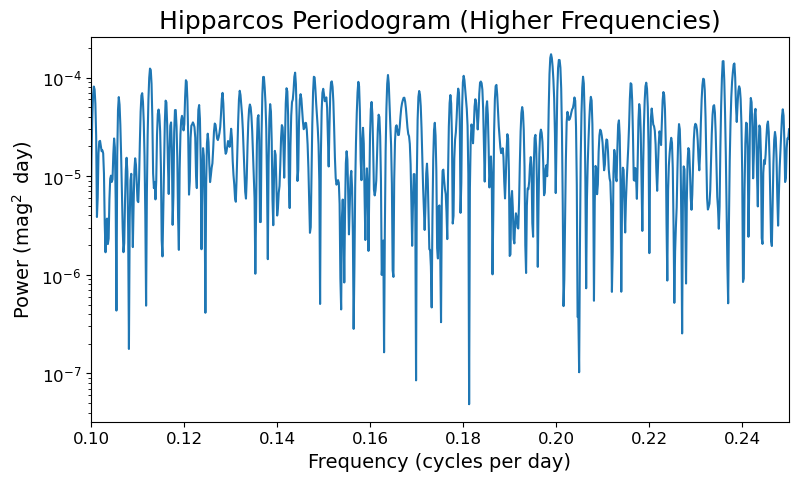

In [29]:
cut_freq, cut_power = LombScargle(tjd - tjd[0], mag, normalization="psd").autopower()

plt.figure(figsize=figsize)
plt.semilogy(cut_freq, cut_power)
plt.title('Hipparcos Periodogram (Higher Frequencies)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"Power ($\operatorname{mag}^2$ day)", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.xlim(0.1, 0.25)
plt.show()

## Spectral Window (Full Data)

A new spectral window is created below using the full data found in the Hipparcos dataset, using a nyquist factor of 2. The red vertical line is for the planet f signal, as it may be due to interference. If this is due to interference, it would be possible to for it to be seen in the spectral window. 

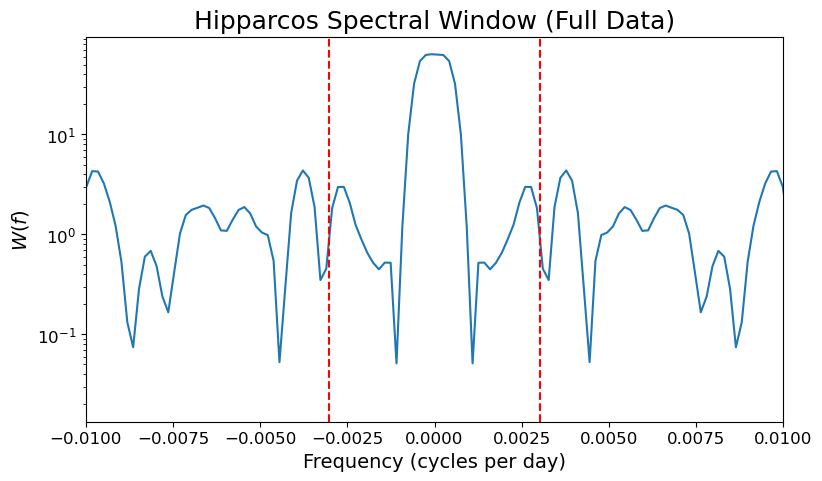

In [30]:
freq, specwin = LombScargle(tjd_full - tjd_full[0], np.ones(len(tjd_full)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Spectral Window (Full Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.axvline(x=1/pf, linestyle='--', color='red')
plt.axvline(x=-(1/pf), linestyle='--', color='red')
plt.tick_params(axis='both', which='major', labelsize=text_font)
#plt.xlim(-0.01, 0.01)
plt.show()

## Spectral Window (Clipped Data)

Another spectral window is created, this time using the sigma-clipped data from the Hipparcos dataset. This also uses a nyquist factor of 2.

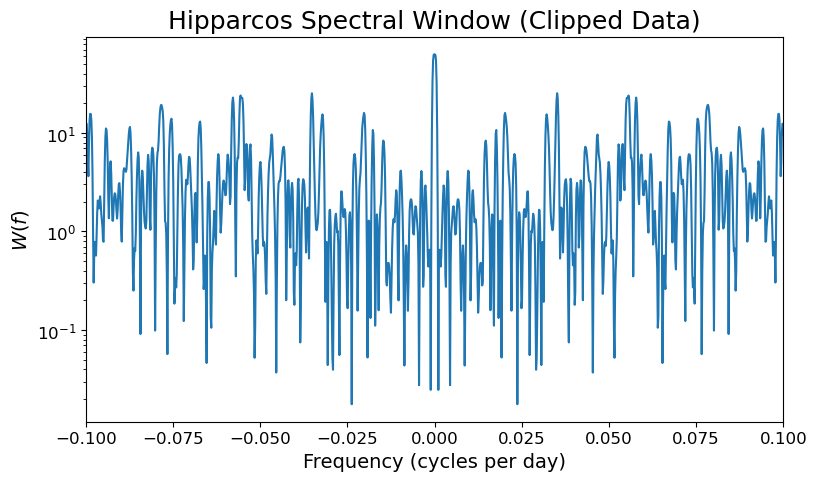

In [10]:
freq, specwin = LombScargle(tjd - tjd[0], np.ones(len(tjd)), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Spectral Window (Clipped Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.xlim(-0.1, 0.1)
plt.show()

## Pseudo-Window (Full Data)

We create a pseudo-window from the full data of the Hipparcos dataset, using a nyquist factor of 2. 

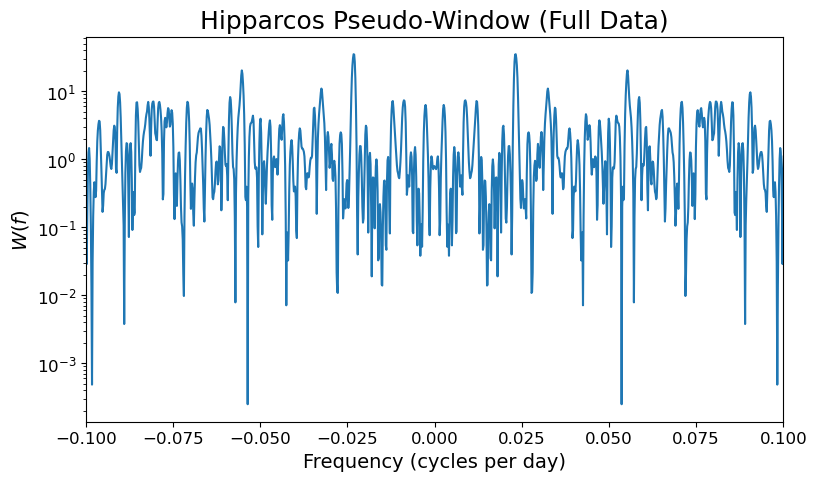

In [11]:
freq, specwin = LombScargle(tjd_full - tjd_full[0], np.sin(2*np.pi*(tjd_full-tjd_full[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

plt.figure(figsize=figsize)
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title('Hipparcos Pseudo-Window (Full Data)', fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.xlim(-0.1, 0.1)
plt.show()

## Pseudo-Window (Clipped Data)

The first plot below shows the pseudo-window using the clipped data of the Hipparcos dataset with a nyquist factor of 2. A vertical line is created at the positive and negative sides for the signal of the reported, possible rotation period. The second plot below is the same pseudo-window using the clipped data of only the positive side.

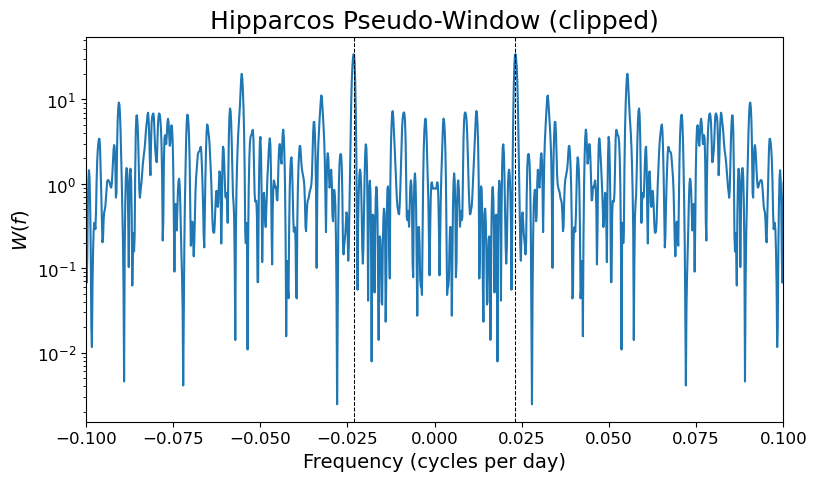

In [12]:
freq, specwin = LombScargle(tjd - tjd[0], np.sin(2*np.pi*(tjd-tjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

plt.figure(figsize=(9, 5))
plt.semilogy(np.concatenate((-freq[::-1], freq[1:])), np.concatenate((specwin[::-1], specwin[1:])))
plt.title("Hipparcos Pseudo-Window (clipped)", fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.xlim(-0.1, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black')
plt.axvline(-(1/rp), linestyle='--', linewidth=0.75, color='black')
plt.show()

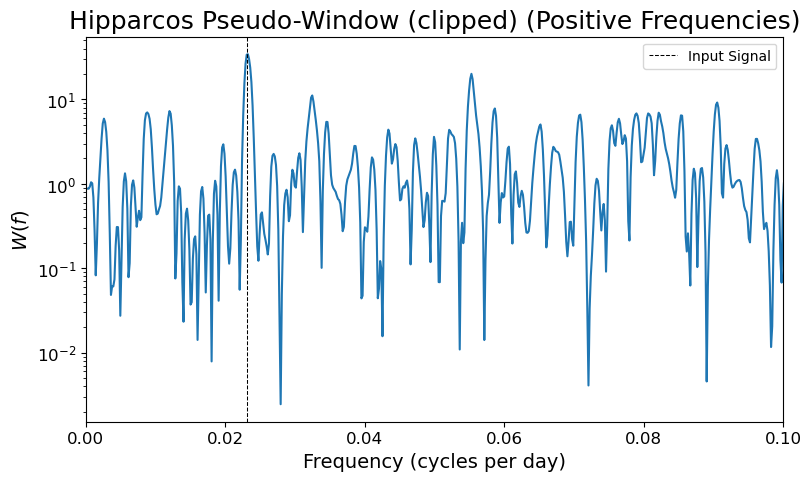

In [20]:
freq, specwin = LombScargle(tjd - tjd[0], np.sin(2*np.pi*(tjd-tjd[0])/rp), center_data = False, fit_mean = False, normalization = 'psd').autopower(nyquist_factor=2)

positive_freq = freq[freq > 0]
positive_specwin = specwin[freq > 0]

plt.figure(figsize=figsize)
plt.semilogy(positive_freq, positive_specwin)
plt.title("Hipparcos Pseudo-Window (clipped) (Positive Frequencies)", fontsize=title_font)
plt.xlabel(r"Frequency (cycles per day)", fontsize=label_font)
plt.ylabel(r"$W(f)$", fontsize=label_font)
plt.tick_params(axis='both', which='major', labelsize=text_font)
plt.xlim(0, 0.1)
plt.axvline(1/rp, linestyle='--', linewidth=0.75, color='black', label='Input Signal')
plt.legend()
plt.show()